In [1]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data_2D_from_3D, get_astro_data, applyTF_2D, Normalize, Stack
from utils import draw_figure,compute_pk,plot_residual
from TF_utils import power_spectrum, getGrid
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import Pk_library as PKL

device = torch.device("cuda:2" if torch.cuda.is_available() else "mps")
print(device)

cuda:1
4
cuda:2


In [6]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4

[rank: 0] Seed set to 7


In [2]:
import importlib
import camel_dataloader

importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data_2D_from_3D, Stack

ModuleNotFoundError: No module named 'camel_dataloader'

In [ ]:
dm_2D = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
    ) #Save 1P grids!
dm_2D.setup(stage=None)

## Check 100 Mpc thick map is applied properly

In [3]:
_, NBody_grid, NBody_mean = getGrid('Astrid', 'LH', 256, '0.0', 'nbody', 30)
NBody_grid_ = np.array(NBody_grid, copy=True)+ 1.0
NBody_grid = NBody_grid_*NBody_mean
print(np.all(NBody_grid.mean(axis = 0) > 0),np.all(NBody_grid.mean(axis = 1) > 0),np.all(NBody_grid.mean(axis = 2) > 0))

True True True


In [4]:
import time
start_time = time.time()
#Stack = torch.nn.DataParallel(Stack(5), device_ids=np.arange(torch.cuda.device_count()))
#Stack = Stack.cuda()
Stack = Stack.to(device)
Nbody_map = Stack(5)(Tensor(np.asarray(NBody_grid)).unsqueeze(0))
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time for one sim: {execution_time:.4f} seconds")
print(Nbody_map.shape)

/tmp/ipykernel_494548/3407603484.py:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  Nbody_map = Stack(5)(Tensor(np.asarray(NBody_grid)).unsqueeze(0))


torch.Size([256, 256, 256])
torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256])


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.imshow(np.log(Nbody_map[0].squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('DM field stacked 100Mpc/h thick', fontsize=24)
plt.tight_layout()
plt.show()

## Check if TF is applied properly in 2D -- Yes! (diff performance for each map)

In [31]:
m_cdm, m_cdm_tf, m_mtot = next(iter(dm_2D.test_dataloader()))
def plot_Pk_postTF(m_cdm, m_cdm_tf, m_mtot): #in overdensity (256,256)
    BoxSize = 25
    grid    = 256     #the map will have grid^2 pixels
    MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
    threads = 1       #number of openmp threads
    axis = 0
    verbose = True
    Pk2D_hydro = PKL.Pk_plane(m_mtot.reshape(256,256).detach().cpu().numpy().astype(np.float32), BoxSize, MAS, threads, verbose)
    Pk2D_Nbody = PKL.Pk_plane(m_cdm.reshape(256,256).detach().cpu().numpy().astype(np.float32), BoxSize,  MAS, threads, verbose)
    Pk2D_postTF = PKL.Pk_plane(m_cdm_tf.reshape(256,256).detach().cpu().numpy().astype(np.float32), BoxSize, MAS, threads, verbose) #dosent look right ~Nbody
    k_Hydro   = Pk2D_hydro.k
    Pk_Hydro   = Pk2D_hydro.Pk
    k_NBody   = Pk2D_Nbody.k
    Pk_NBody   = Pk2D_Nbody.Pk
    k_postTF   = Pk2D_postTF.k
    Pk_postTF   = Pk2D_postTF.Pk

    plt.figure()
    mask = k_Hydro <= 10
    plt.plot(k_Hydro[mask], Pk_Hydro[mask], label='Hydro')
    plt.plot(k_NBody[mask], Pk_NBody[mask], label='NBody')
    plt.plot(k_postTF[mask], Pk_postTF[mask], label='postTF')    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'P(k)', fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.tight_layout()     
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    plt.show()

In [10]:
import importlib
import camel_dataloader

importlib.reload(camel_dataloader) 
from camel_dataloader import applyTF_2D

cuda
4


0.972044
0.972044
0.95670104
0.95670104
0.6425476

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


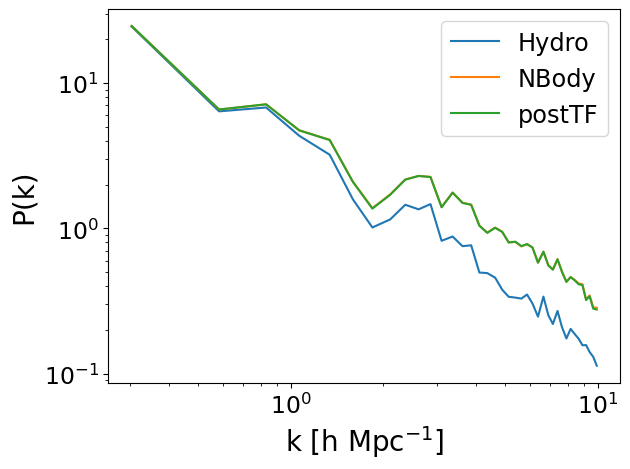


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


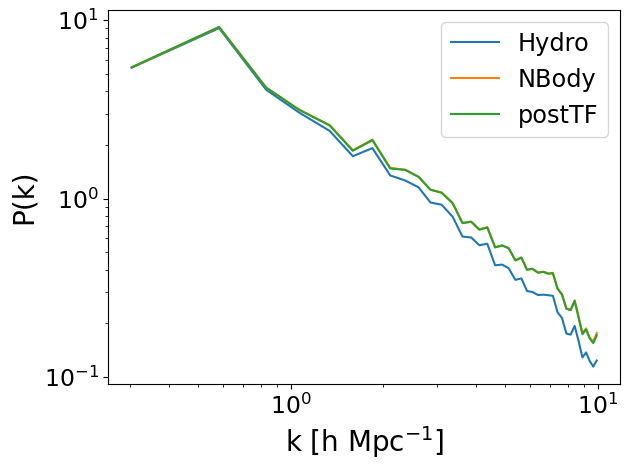


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


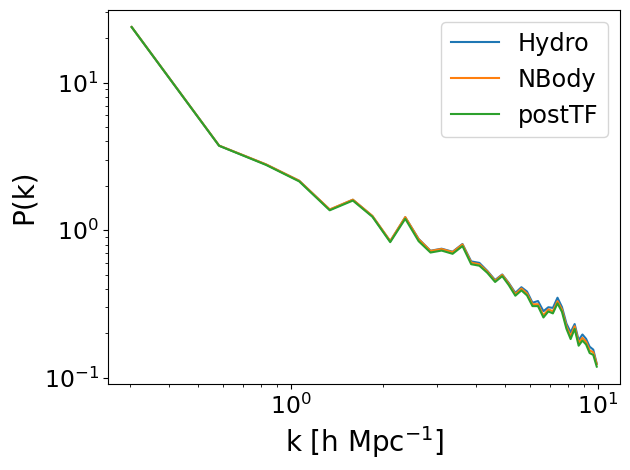


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


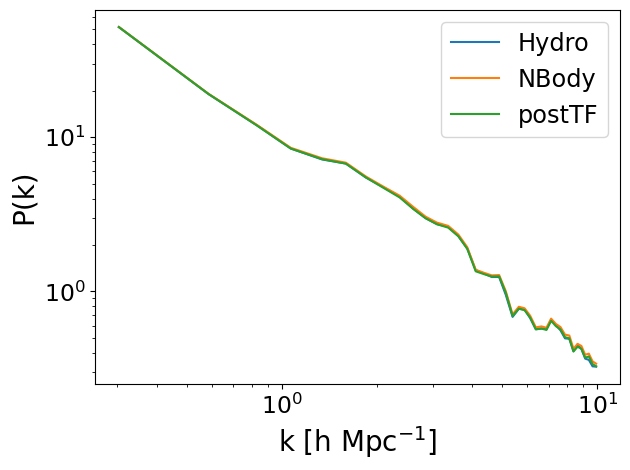


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


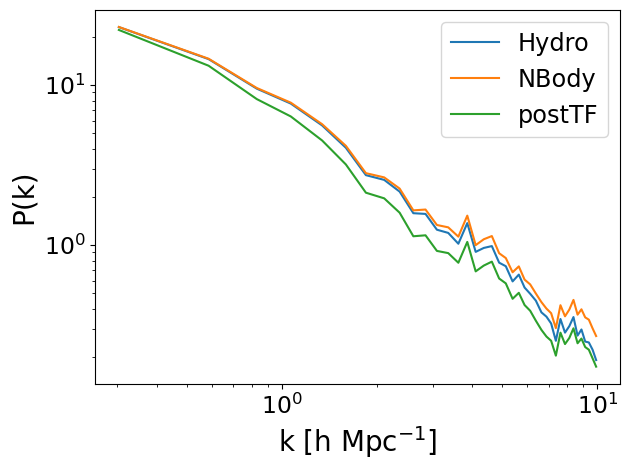

In [23]:
applyTF_train=applyTF_2D(boxsize=25.0, sim= dataset,res = 256, s= 'LH', redshift= '0.0')
post_TF0 = applyTF_train(m_cdm[0].reshape(256,256)-1,0)
post_TF2 = applyTF_train(m_cdm[2].reshape(256,256)-1,2) #//3 have same ratios
post_TF5 = applyTF_train(m_cdm[5].reshape(256,256)-1,5)
post_TF3 = applyTF_train(m_cdm[3].reshape(256,256)-1,3)
post_TF10 = applyTF_train(m_cdm[10].reshape(256,256)-1,10)

plot_Pk_postTF(m_cdm[0]-1, post_TF0, m_mtot[0]-1)
plot_Pk_postTF(m_cdm[2]-1, post_TF2, m_mtot[2]-1)
plot_Pk_postTF(m_cdm[5]-1, post_TF5, m_mtot[5]-1)
plot_Pk_postTF(m_cdm[3]-1, post_TF3, m_mtot[3]-1)
plot_Pk_postTF(m_cdm[10]-1, post_TF10, m_mtot[10]-1)

In [28]:
def plot_residual_fields(sim_indx):
    diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm_tf[sim_indx])
    plt.figure()
    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom', colors)
    im = plt.imshow(diff.reshape(256,256), cmap=cmap, vmin=-2, vmax=2)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'Hydro - postTF: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

    diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm[sim_indx])
    plt.figure()
    im = plt.imshow(diff.reshape(256,256), cmap=cmap, vmin=-2, vmax=2)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'Hydro - NBody: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

    plt.figure()
    im = plt.imshow(np.log(m_cdm[sim_indx].reshape(256,256).squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'map_DM: {m_cdm.mean():.2e} +/- {m_cdm.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_32375/4177219702.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm_tf[sim_indx])


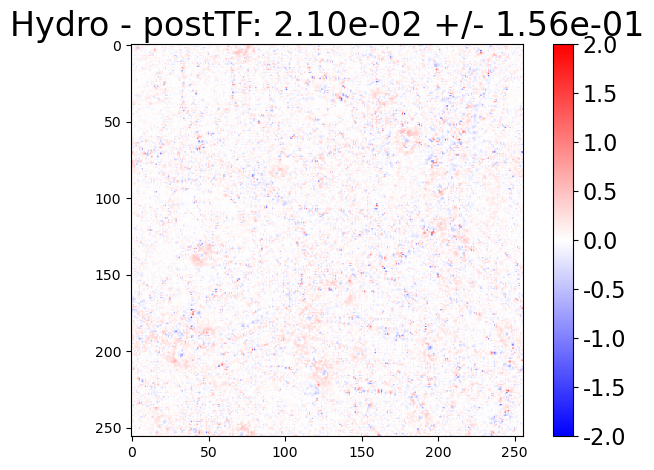

/tmp/ipykernel_32375/4177219702.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = np.log(m_mtot[sim_indx]) - np.log(m_cdm[sim_indx])


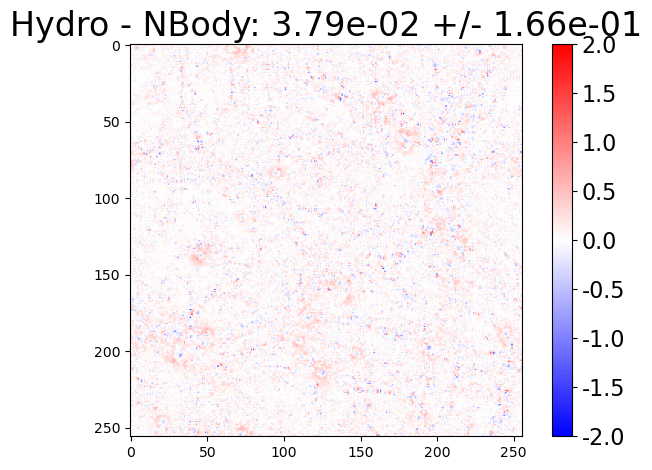

/tmp/ipykernel_32375/4177219702.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  im = plt.imshow(np.log(m_cdm[sim_indx].reshape(256,256).squeeze().cpu()), cmap='viridis', vmin=-2, vmax=5)


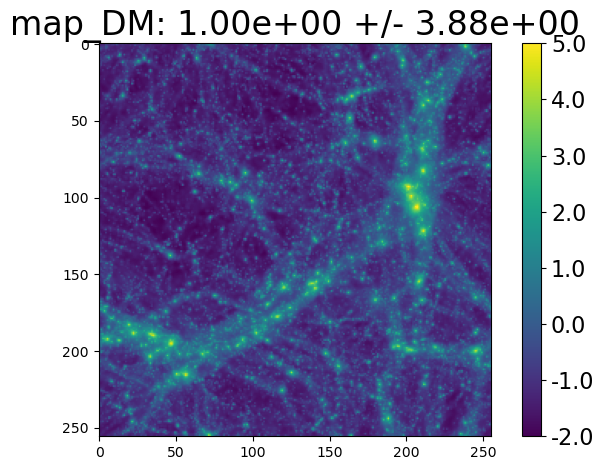

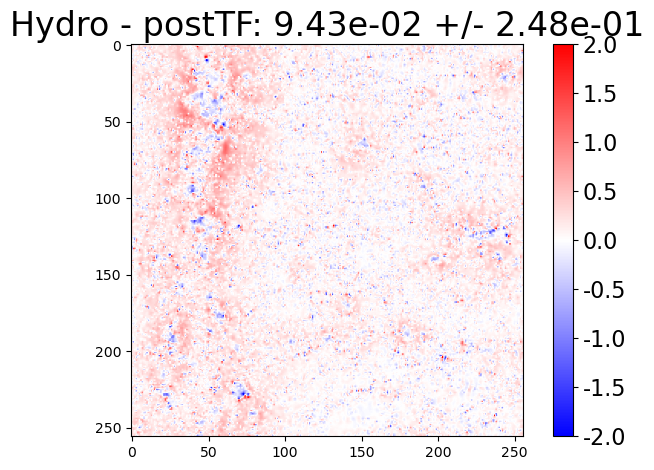

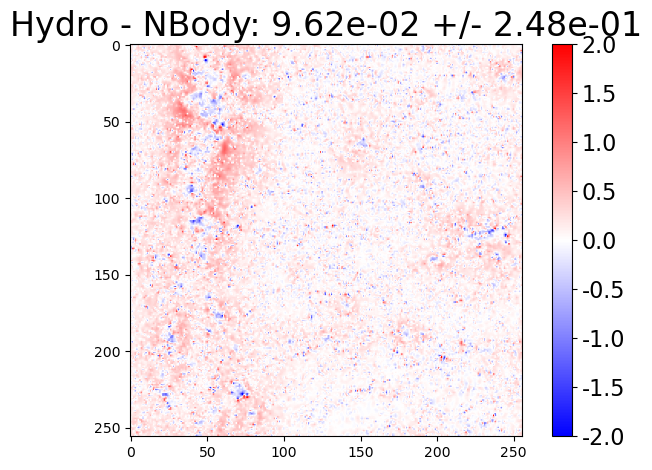

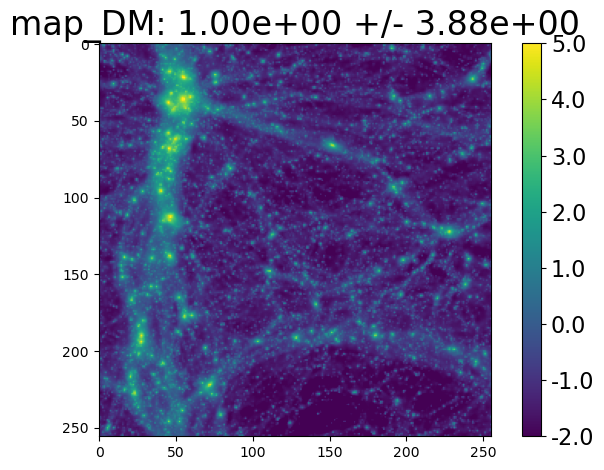

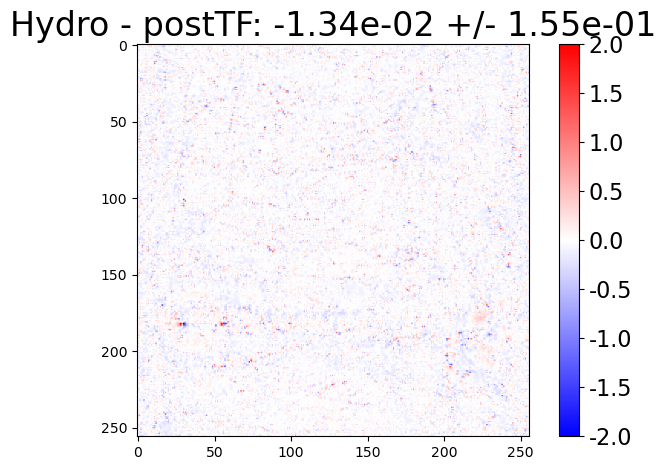

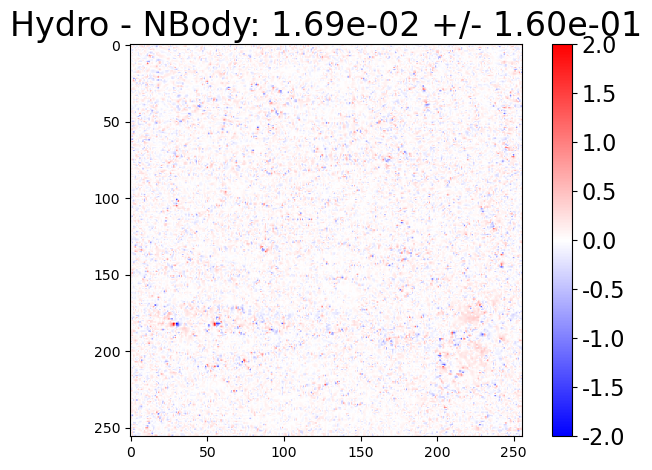

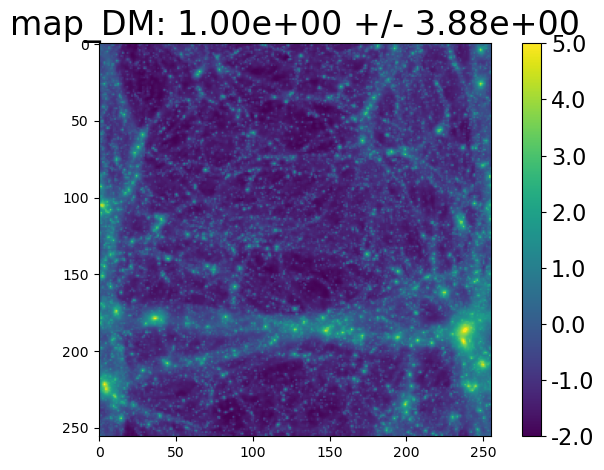

In [30]:
plot_residual_fields(10)
plot_residual_fields(9)
plot_residual_fields(3)